In [1]:
from sklearn.preprocessing import RobustScaler
import numpy as np
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split

# Spotify Popularity Predictor (39%)

The goal of this challenge is to create a model that predicts the popularity of a song based on its features.

The dataset contains a list of tracks with the following characteristics:
- `acousticness`: whether the track is acoustic
- `danceability`: describes how suitable a track is for dancing
- `duration_ms`: duration of the track in milliseconds
- `energy`: represents a perceptual measure of intensity and activity
- `explicit`: whether the track has explicit lyrics
- `id`: id for the track
- `instrumentalness`: predicts whether a track contains no vocals
- `key`: the key the track is in
- `liveness`: detects the presence of an audience in the recording
- `loudness`: the overall loudness of a track in decibels
- `mode`: modality of a track
- `name`: name of the track
- `popularity`: popularity of the track
- `release_date`: release date
- `speechiness`: detects the presence of spoken words in a track
- `tempo`: overall estimated tempo of a track in beats per minute
- `valence`: describes the musical positiveness conveyed by a track
- `artist`: artist who performed the track

# Model

## Data collection

**📝 Load the `spotify_popularity_train.csv` dataset from the provided URL. Display the first few rows. Perform the usual cleaning operations. Store the result in a `DataFrame` named `data`.**

👉 Do not forget to clean the dataset

In [2]:
url = "https://wagon-public-datasets.s3.amazonaws.com/certification_paris_2021Q1/spotify_popularity_train.csv"

In [3]:
import pandas as pd
data = pd.read_csv(url)
data.head(3)

,acousticness,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,artist
0,0.65400,0.499,219827,0.190,0,0B6BeEUd6UwFlbsHMQKjob,0.00409,7,0.0898,-16.435,1,Back in the Goodle Days,40,1971,0.0454,149.460,0.4300,John Hartford
1,0.00592,0.439,483948,0.808,0,5Gpx4lJy3vKmIvjwbiR5c8,0.14000,2,0.0890,-8.497,1,Worlds Which Break Us - Intro Mix,22,2015-02-02,0.0677,138.040,0.0587,Driftmoon
2,0.73400,0.523,245693,0.288,0,7MxuUYqrCIy93h1EEHrIrL,0.00000,0,0.0771,-11.506,1,I'm The Greatest Star,40,1968-09-01,0.2140,75.869,0.4640,Barbra Streisand


In [4]:
#Checking the number of missing values
data.isnull().sum().sort_values(ascending=False)

#Replacing missing artists
data.artist.replace(np.nan, "Unknown", inplace=True)

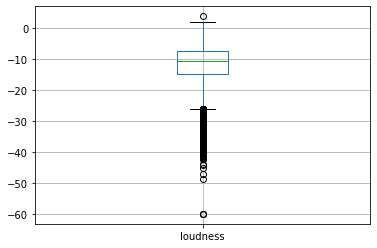

In [5]:
#Checking distribution and identifying outliers
data[['loudness']].boxplot()

#Using a Robust Scaler on Loudness
r_scaler = RobustScaler()
r_scaler.fit(data[['loudness']])
data['loudness'] = r_scaler.transform(data[['loudness']])

In [6]:
#Harmonizing release date keeping the year only
def year_only(date):
    date = date[0:4]
    return date
    
data['year'] = data.release_date.apply(year_only)

### Save your results

Run the following cell to save your results.

In [7]:
from nbresult import ChallengeResult

ChallengeResult(
    "c5_data_cleaning",
    data=data).write()

## Baseline

**📝 We want to use a metric that measures the prediction error in the same unit than `popularity`. In addition, it should strongly penalize largest errors. Which sklearn's [metric](https://scikit-learn.org/stable/modules/model_evaluation.html) should we use? Store its exact name as string below**

In [8]:
scoring = "mean squared error"
#we will use the root mean squared error to both strongly penalize errors and measure the prediction error in the same unit as popularity

**📝 Let's build a baseline model using only the numerical features in our dataset.**
- Build `X_baseline` with only numerical features
- Build `y` your target containing the `popularity`
- Then 5 times cross validate the baseline linear model of your choice (do not fine tune it)
- Store your mean performance in a `float` variable named `baseline_score`

In [9]:
# Preparing X and y
X_baseline = data[['acousticness', 'artist', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'year', 'speechiness', 'tempo', 'valence']]
y = data[['popularity']]

# Baseline model that predicts "median"
baseline_model = DummyRegressor(strategy="median") 

# cross validate baseline
cv_results = cross_validate(baseline_model, X_baseline, y) 
baseline_score = cv_results['test_score'].mean()
baseline_score

-0.0008176493102242333

### Save your results

Run the following cell to save your results.

In [10]:
from nbresult import ChallengeResult

ChallengeResult(
    "baseline",
    scoring=scoring,
    baseline_score=baseline_score).write()

## Feature engineering

Let's now use the features that we left aside: `release_date` and `artist` to improve the performance of our model. We'll create them manually in a train vs. test context first (and pipeline them later)

### holdout
**📝 Create the 4 variables `X_train` `y_train`, `X_test`, `y_test` with a 50% split with random sampling**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_baseline, y, test_size=0.5)

### year

**📝 Create `X_train_year` and `X_test_year` by adding the new column `year` containing the release year of the track as integer**

In [12]:
X_train_year = X_train
X_test_year = X_test

### artist

How could we use the `artist` column? There are too many artists to one hot encode it.  
We could instead create an `artist_popularity` feature containing the mean popularity of an artist, computed as the mean popularity of all tracks the artist released _on the train set_.

#### Process artist popularity from the Training set

**📝 Compute and store the `artist_popularity` as a new pandas `Series`**  

In [13]:
data_grouped_train = data.iloc[X_train.index].groupby(by='artist').mean()
data_grouped_train = data_grouped_train.rename(columns={'popularity': 'artist_popularity'})

In [14]:
data_grouped_train

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,artist_popularity,speechiness,tempo,valence
artist,,,,,,,,,,,,,,
"""Weird Al"" Yankovic",0.157638,0.625385,264524.076923,0.683154,0.0,0.000003,5.769231,0.127154,0.112343,0.615385,35.230769,0.078192,147.881308,0.726000
$NOT,0.190000,0.902000,167147.000000,0.462000,1.0,0.000002,7.000000,0.094000,0.387439,1.000000,72.000000,0.097900,103.984000,0.646000
$tar$eed,0.037500,0.923000,130375.000000,0.172000,1.0,0.020200,10.000000,0.082700,-0.648198,0.000000,0.000000,0.385000,100.046000,0.176000
$uicideBoy$,0.323900,0.581000,177227.000000,0.427667,1.0,0.195800,3.333333,0.126667,0.360230,0.666667,67.666667,0.226733,106.050333,0.137767
'Til Tuesday,0.098900,0.349000,280067.000000,0.691000,0.0,0.000216,8.000000,0.080100,0.434911,1.000000,27.000000,0.032900,80.065000,0.199000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
羅大佑,0.149000,0.690000,317587.000000,0.478000,0.0,0.000078,4.000000,0.263000,0.451318,1.000000,38.000000,0.029700,112.339000,0.665000
葛蘭,0.908000,0.487000,192040.000000,0.148000,0.0,0.000001,3.000000,0.239000,-0.281737,1.000000,0.000000,0.044300,71.792000,0.352000
許冠英,0.644000,0.490000,190453.000000,0.372000,0.0,0.000001,5.000000,0.367000,0.237359,1.000000,32.000000,0.028000,113.448000,0.500000


#### Apply the artist popularity to `X_train_year`

**📝 Create a new DataFrame `X_train_engineered` which adds a new column to the existing `X_train_year` with the `artist_popularity` corresponding to the song's artist.** 

🚨 Make sure that the target `popularity` does not end up in `X_train_engineered` 

In [15]:
X_train_engineered = X_train_year.copy()
X_train_engineered = X_train_engineered.set_index('artist')
X_train_engineered['artist_popularity'] = data_grouped_train['artist_popularity']
X_train_engineered

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,year,speechiness,tempo,valence,artist_popularity
artist,,,,,,,,,,,,,,,
The Chemical Brothers,0.1190,0.632,290493,0.92000,0,0.508000,2,0.1140,0.786713,1,1999,0.0531,127.001,0.363,52.000000
Nat King Cole,0.7660,0.772,148107,0.34300,0,0.000000,0,0.0684,0.029048,1,1959,0.2080,132.447,0.827,30.820513
Reba McEntire,0.6430,0.586,268867,0.42300,0,0.000000,0,0.1290,0.117671,1,1999,0.0267,122.625,0.268,37.333333
Frédéric Chopin,0.9920,0.442,93053,0.00978,0,0.846000,7,0.0719,-2.026224,0,1946,0.0354,60.629,0.319,6.312102
Curtis Fuller Quintet,0.9320,0.449,320493,0.11400,0,0.346000,11,0.0883,-1.258203,0,1959,0.0455,171.002,0.636,27.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nat King Cole,0.9490,0.574,107960,0.16800,0,0.000000,7,0.0955,-1.127891,0,1952,0.1490,183.678,0.870,30.820513
Juthika Roy,0.9940,0.475,194000,0.10700,0,0.950000,0,0.2970,-0.892146,1,1941,0.0320,73.018,0.368,0.000000
Queens of the Stone Age,0.0359,0.507,278707,0.58800,0,0.000129,0,0.3730,0.799489,1,2002,0.0641,170.889,0.637,43.333333


#### Apply the artist popularity to `X_test_year`

**📝 Similarily, create a new DataFrame `X_test_engineered` which also adds a new column to the existing `X_test_year` with the `artist_popularity` corresponding to the song's artist, computed from the training set.**

🚨**If an artist has never been seen in the training set, use the global mean popularity of all the tracks of `X_train`**

In [16]:
X_test_engineered = X_test_year.copy()
X_test_engineered = X_test_engineered.set_index('artist')
X_test_engineered['artist_popularity'] = data_grouped_train['artist_popularity']

In [17]:
y_train['popularity'].mean()

25.688928817187858

In [18]:
X_test_engineered.artist_popularity.replace(np.nan, y_train['popularity'].mean(), inplace=True)

### Save your results

Run the following cell to save your results.

In [19]:
from nbresult import ChallengeResult

_ = pd.concat([X_train_engineered, X_test_engineered])

ChallengeResult("c7_feature_engineering",
    shape = _.shape,
    cols = _.columns,
    years = _.get("year"),
    popularities = _.get("artist_popularity"),
).write()

### Performance

**📝 Let's see how these features impact the performance of our model. Retrain the same baseline model on numerical values only, but adding the new features `year` and `artist_popularity`, and see how the performance is impacted. Save the performance in a `float` variable named `score_engineered`**

👉 Do not fine tune the model yet

In [20]:
X_train_engineered

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,year,speechiness,tempo,valence,artist_popularity
artist,,,,,,,,,,,,,,,
The Chemical Brothers,0.1190,0.632,290493,0.92000,0,0.508000,2,0.1140,0.786713,1,1999,0.0531,127.001,0.363,52.000000
Nat King Cole,0.7660,0.772,148107,0.34300,0,0.000000,0,0.0684,0.029048,1,1959,0.2080,132.447,0.827,30.820513
Reba McEntire,0.6430,0.586,268867,0.42300,0,0.000000,0,0.1290,0.117671,1,1999,0.0267,122.625,0.268,37.333333
Frédéric Chopin,0.9920,0.442,93053,0.00978,0,0.846000,7,0.0719,-2.026224,0,1946,0.0354,60.629,0.319,6.312102
Curtis Fuller Quintet,0.9320,0.449,320493,0.11400,0,0.346000,11,0.0883,-1.258203,0,1959,0.0455,171.002,0.636,27.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Nat King Cole,0.9490,0.574,107960,0.16800,0,0.000000,7,0.0955,-1.127891,0,1952,0.1490,183.678,0.870,30.820513
Juthika Roy,0.9940,0.475,194000,0.10700,0,0.950000,0,0.2970,-0.892146,1,1941,0.0320,73.018,0.368,0.000000
Queens of the Stone Age,0.0359,0.507,278707,0.58800,0,0.000129,0,0.3730,0.799489,1,2002,0.0641,170.889,0.637,43.333333


In [21]:
# Preparing X and y
X_baseline = X_train_engineered[['acousticness', 'danceability', 'duration_ms', 'energy', 'explicit', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'year', 'speechiness', 'tempo', 'valence', 'artist_popularity']]
y = y_train[['popularity']]

# Baseline model that predicts "median"
baseline_model = DummyRegressor(strategy="median") 

# cross validate baseline
cv_results = cross_validate(baseline_model, X_baseline, y) 
score_engineered = cv_results['test_score'].mean()
score_engineered

-0.001221169765163488

### Save your results

Run the following cell to save your results.

In [22]:
from nbresult import ChallengeResult

ChallengeResult(
    "c7_score_engineering",
    scoring=scoring,
    score_engineered=score_engineered).write()

## Pipelining

**📝 Let's create a full sklearn preprocessing pipeline called `preproc`. It should integrate our feature engineering for `year` and `artist_popularity`, as well as any other preprocessing of your choice**

**Store also the number of columns/feature after preprocessing your inputs in a variable `col_number`**

**🚨⚠️ Advice: SKIP the `ArtistPopularityTransformer` if you don't have time to do it. It is better for you to have a working pipeline rather than NO pipeline at all**

In [23]:
# 👉 Do not hesitate to reload clean new dataset if you need a fresh start
y = data.popularity
X = data.drop("popularity", axis=1)

In [24]:
# Run this cell to visualize your pipeline as you build it
from sklearn import set_config; set_config(display='diagram')

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin

In [30]:
class ArtistPopularityTransformer(BaseEstimator, TransformerMixin):

    def __init__(self):
        self.BaseEstimator = BaseEstimator
        self.TransformerMixin = TransformerMixin

    def fit(self, X, y=None):
        """
        process artist mean popularity from artists songs popularity
        process song global mean popularity
        """

        # process artist popularity
        self.artist_popularity = pd.concat([X, y],
                               axis=1,
                               join='inner').groupby(by='artist').mean()['popularity']
        # process mean popularity
        self.mean_train_popularity = y.mean()
        
        return self

    def transform(self, X, y=None):
        """
        apply artist mean popularity vs song global mean popularity to songs
        """

        # inject artist popularity
        X_copy = X.join(self.artist_popularity, on='artist')\
                    .rename(columns={"popularity": "artist_popularity"})\
                    .drop(columns='artist')
        
        # fills popularity of unknown artists with song global mean popularity
        X_copy['artist_popularity'].fillna(self.mean_train_popularity, inplace=True)

        return X_copy # TODO return X_copy

In [31]:
class YearEngineering(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        """
        Transform the release_dat in year (int)
        """
        X['year'] = X['release_date'].map(lambda x: x[:4]).astype(int)
        X_copy = X.drop(columns='release_date')
        return X_copy

In [33]:
preproc = make_column_transformer(
    (MinMaxScaler(), ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo','valence']),
    (ArtistPopularityTransformer(), ['artist']), 
     (YearEngineering(), ['release_date']),
    remainder='passthrough'
    )

In [34]:
pd.DataFrame(preproc.fit_transform(X,y)).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.656627,0.506085,0.044604,0.19,0.00409,0.08989,0.683437,0.046804,0.613781,0.43,35.0,1971,0,0B6BeEUd6UwFlbsHMQKjob,7,1,Back in the Goodle Days,1971
1,0.005944,0.445233,0.099696,0.808,0.14,0.089089,0.807966,0.069794,0.566883,0.0587,10.0,2015,0,5Gpx4lJy3vKmIvjwbiR5c8,2,1,Worlds Which Break Us - Intro Mix,2015
2,0.736948,0.530426,0.049999,0.288,0.0,0.077177,0.760762,0.220619,0.311568,0.464,34.333333,1968,0,7MxuUYqrCIy93h1EEHrIrL,0,1,I'm The Greatest Star,1968
3,0.430723,0.690669,0.025872,0.165,0.0,0.394394,0.604653,0.975258,0.596833,0.288,3.770732,1926,0,4GeYbfIx1vSQXTfQb1m8Th,11,0,Kapitel 281 - Der Page und die Herzogin,1926
4,0.564257,0.55071,0.025828,0.575,0.000004,0.127127,0.825584,0.02732,0.571942,0.801,13.210526,2008,0,2JPGGZwajjMk0vvhfC17RK,2,1,Away from You,2008


In [35]:
col_number = len(list(pd.DataFrame(preproc.fit_transform(X,y)).columns))
col_number

18

#### Save your results

Run the following cell to save your results.

In [36]:
# Print below your preproc here for the correctors
from sklearn import set_config; set_config(display='diagram')
preproc

ColumnTransformer(remainder='passthrough',
                  transformers=[('minmaxscaler', MinMaxScaler(),
                                 ['acousticness', 'danceability', 'duration_ms',
                                  'energy', 'instrumentalness', 'liveness',
                                  'loudness', 'speechiness', 'tempo',
                                  'valence']),
                                ('artistpopularitytransformer',
                                 ArtistPopularityTransformer(), ['artist']),
                                ('yearengineering', YearEngineering(),
                                 ['release_date'])])

In [37]:
from nbresult import ChallengeResult

ChallengeResult(
    "c6_preprocessing",
    col_number=col_number
).write()

## Training

📝 Time to optimize 

- **Add an estimator to your pipeline (only from scikit-learn)** 

- **Train your pipeline and fine-tune (optimize) your estimator to get the best prediction score**

- **You must create 2 pipelines (one with a linear model, one with an ensemble model)**

Then, 

- Save your two best 5-time cross-validated scores as _float_: `score_linear` and `score_ensemble`

- Save your two best trained pipelines as _Pipeline_ objects: `pipe_linear` and `pipe_ensemble`

### Linear

In [79]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

final_pipe_trained = preproc.fit(X_train, y_train)

In [80]:
final_pipe_trained.get_params()

{'n_jobs': None,
 'remainder': 'passthrough',
 'sparse_threshold': 0.3,
 'transformer_weights': None,
 'transformers': [('minmaxscaler',
   MinMaxScaler(),
   ['acousticness',
    'danceability',
    'duration_ms',
    'energy',
    'instrumentalness',
    'liveness',
    'loudness',
    'speechiness',
    'tempo',
    'valence']),
  ('artistpopularitytransformer', ArtistPopularityTransformer(), ['artist']),
  ('yearengineering', YearEngineering(), ['release_date'])],
 'verbose': False,
 'minmaxscaler': MinMaxScaler(),
 'artistpopularitytransformer': ArtistPopularityTransformer(),
 'yearengineering': YearEngineering(),
 'minmaxscaler__clip': False,
 'minmaxscaler__copy': True,
 'minmaxscaler__feature_range': (0, 1)}

In [81]:
from sklearn.model_selection import GridSearchCV

# Instanciate grid search
grid_search = GridSearchCV(
    final_pipe_trained, 
    param_grid={
        'sparse_threshold': [0.1, 0.2, 0.3, 0.4, 0.5]},
        cv=5,
        scoring ='r2')

grid_search.fit(X_train, y_train)
grid_search.best_params_

/home/elan/.pyenv/versions/3.8.6/envs/backinthessr/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elan/.pyenv/versions/3.8.6/envs/backinthessr/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/elan/.pyenv/versions/3.8.6/envs/backinthessr/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/elan/.pyenv/versions/3.8.6/envs/backinthessr/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/elan/.pyenv/versions/3.8.6/envs/backinthessr/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 53, in 

/home/elan/.pyenv/versions/3.8.6/envs/backinthessr/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elan/.pyenv/versions/3.8.6/envs/backinthessr/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/elan/.pyenv/versions/3.8.6/envs/backinthessr/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/elan/.pyenv/versions/3.8.6/envs/backinthessr/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/elan/.pyenv/versions/3.8.6/envs/backinthessr/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 53, in 

/home/elan/.pyenv/versions/3.8.6/envs/backinthessr/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/elan/.pyenv/versions/3.8.6/envs/backinthessr/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/home/elan/.pyenv/versions/3.8.6/envs/backinthessr/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 199, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true,
  File "/home/elan/.pyenv/versions/3.8.6/envs/backinthessr/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 236, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/home/elan/.pyenv/versions/3.8.6/envs/backinthessr/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 53, in 

{'sparse_threshold': 0.1}

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

pipe_linear = Pipeline([
    ('preprocessing', preproc),
    ('linear_regression', Ridge())])
pipe_linear

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('minmaxscaler',
                                                  MinMaxScaler(),
                                                  ['acousticness',
                                                   'danceability',
                                                   'duration_ms', 'energy',
                                                   'instrumentalness',
                                                   'liveness', 'loudness',
                                                   'speechiness', 'tempo',
                                                   'valence']),
                                                 ('artistpopularitytransformer',
                                                  ArtistPopularityTransformer(),
                                                  ['artist']),
                                                 ('yearengineering',
                                                  YearEngineering(),
                                                  ['release_date'])])),
                ('linear_regression', Ridge())])

In [83]:
X_train = X_train.drop(['id', 'name'], axis=1)
X_test = X_test.drop(['id', 'name'], axis=1)

In [86]:
# Train pipeline
pipe_linear_trained = pipe_linear.fit(X_train,y_train)

# Make predictions
pipe_linear_trained.predict(X_test)

# Score model
score_linear = pipe_linear_trained.score(X_test,y_test)

### Ensemble

In [ ]:
from sklearn.ensemble import RandomForestRegressor

pipe_ensemble = Pipeline([
    ('preprocessing', preproc),
    ('rando', RandomForestRegressor())])
pipe_ensemble

In [ ]:
# Train pipeline
pipe_ensemble_trained = pipe_ensemble.fit(X_train,y_train)

# Make predictions
pipe_ensemble_trained.predict(X_test)

# Score model
score_ensemble = pipe_linear_trained.score(X_test,y_test)

### Save your results

Run the following cell to save your results.

In [ ]:
# Print below your best pipe for correction purpose
from sklearn import set_config; set_config(display='diagram')
pipe_linear

In [ ]:
# Print below your best pipe for correction purpose
pipe_ensemble

In [ ]:
from nbresult import ChallengeResult

ChallengeResult("c8_c9_c11_c13_model_tuning",
    scoring = scoring,
    score_linear=score_linear,
    score_ensemble=score_ensemble).write()

## API 

Time to put a pipeline in production!

👉 Go to https://github.com/lewagon/data-certification-api and follow instructions

**This final part is independent from the above notebook**